# Analyzing Family WhatsApp Group Chat for Yearly Family Quiz Insights

Welcome to our Jupyter notebook, where we will dive into the data from our family WhatsApp group chat. The goal of this analysis is to extract interesting and fun insights that can be used in our annual family quiz. By examining the messages exchanged over the past year, we hope to uncover trends and intriguing details that will make our quiz more engaging and personalized.

### Limitations of the Analysis

Before we begin, it's important to acknowledge some limitations in our analysis:

-Missing Messages with Photos: The text data we have does not include messages that come with photos. Given that quite a few of our conversations involve sharing pictures, this omission means that some context and interactions are not captured in our dataset.

-Incomplete Texts: Similarly, any other media types (videos, voice notes, etc.) are also excluded, which might affect the comprehensiveness of our insights.


Despite these limitations, we believe that the data we do have will still provide valuable and entertaining material for our family quiz. Let's get started and see what interesting patterns and facts we can uncover from our family chat!

Steps :

1. Import data set
2. process the data into a pandas data frame
3. clean the data
4. get data including : 
    1. Who sent in the most and least messages ( graph?)
    2. Who used the most emojis?
    3. Who asked the most questions?
    4. Night Owl - who sent the most messages late at night?
        EXTRA : distribution of when people sent messages over the day
    5. Who was most popular / Whos name was mentioned most in the chat?
    6. Best Friends : Which two people interacted most in the chat?
    7. Who sent the longest messages?
        EXTRA : distribution of different messages 



    EXTRA
    7. Word map - What was the most popular word?
    8




## Imports

In [1]:
import re
import pandas as pd
import emoji

# for plotting graphs

import seaborn as sns
import matplotlib.pyplot as plt



## Data Processing

The first thing to do is to process the Whatsapp Text file and get the data into a pandas dataframe. For this we are using regex to be able to differentiate the author, time stamp and message in each whatsapp text sent

In [302]:
# Importing the data

DATE_TIME = re.compile(r"([(\[]).*?([)\]])")
AUTHOR = re.compile(r"((( [a-zA-ZöäüÖÄÜ]+)+):)")
LTR = chr(8206)

def to_pd_row(s):
    match = DATE_TIME.match(s)
    if match:
        g = match.group(0)
        date = pd.to_datetime(g[1:11])
        time = g[13:-1]
        author = re.search(AUTHOR, s).group(0)[1:-1]
        message = s.split(': ')[1]
        return date, time, author, message.replace("\n", "")

def chat():
    filename = "./chatMay2024.txt"
    try:
        with open(filename) as f:
            for l in f.readlines():
                yield to_pd_row(l.replace(LTR, ""))
        f.close()
    except Exception as e:
        print(f"Could not process {filename}, because the following error occured: {type(e).__name__}: {str(e)}")

if __name__ == "__main__":
    df = pd.DataFrame(data=list(chat()), columns=["Date", "Time", "Author", "Message"])


/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_55429/226887811.py:11: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



## Data Cleaning

The next step is to do some data cleaning. 
Firstly, as the quiz is done only for the texts sent in the recent year, we are filtering out any data of messages sent before 2024.
I am then changing each of the labels to what I have them saved as in my contacts to their first names so the quiz is not just in my perspective but for the whole family.

In [348]:
filtered_df = df.loc[df['Date'] > '2024-01-01']

filtered_df = filtered_df.drop(filtered_df[filtered_df.Author == "Grandpa"].index)

#replace label names saved in my contacts to proper names 
# Define the mapping of old labels to new labels
label_mapping = {
    'Cesca': 'Francesca',
    'Mother Teresa': 'Teresa',
    'Aunty Denise': 'Denise',
    'Aunty kim': 'Kim',
    'Dad': 'Kevin',
    'Uncle Bob': 'Bob'
}

# # Rename the category labels using replace
filtered_df['Author'] = filtered_df['Author'].replace(label_mapping)

#filtered_df["Author"] = filtered_df["Author"].astype("category")
print(len(filtered_df))

2217


Bellow is some code if you wish to export the data to an excel file and do a quick visual check

In [72]:
# Export the DataFrame to an Excel file
# filtered_df.to_excel('chatApril.xlsx', index=False)
# print('DataFrame is written to Excel File successfully.')

Start off by creating a word map of the most common words used in the chat

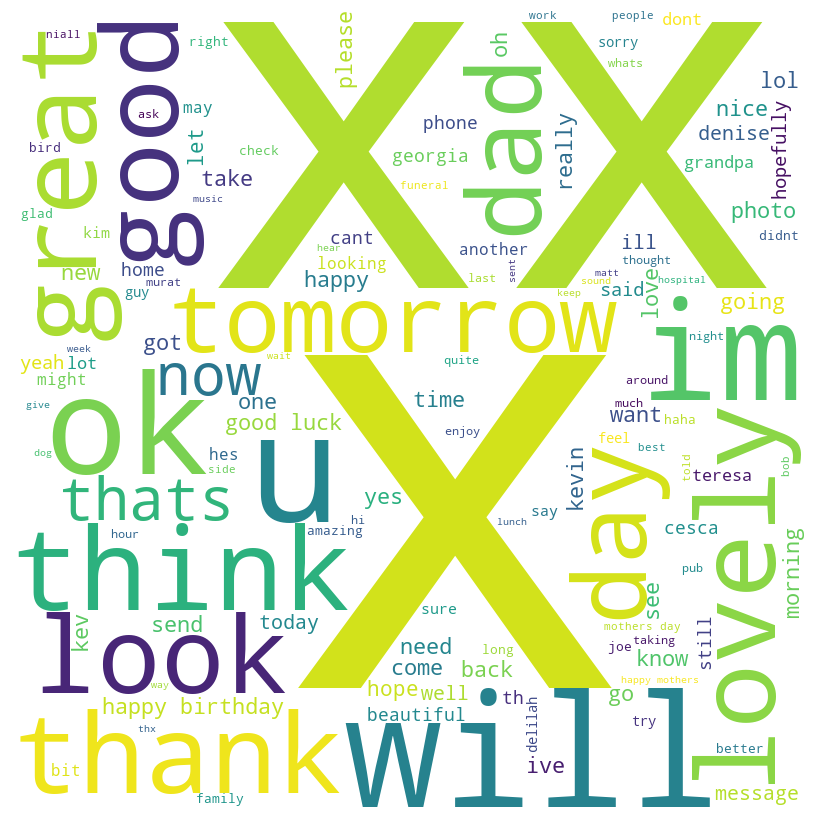

In [304]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#removes urls, normalize whitespace and make all lower case
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+',' ', text)
    text = re.sub(r'[^\w\s]|_', '', text)
    text = re.sub(r'[0-9]+','', text)
    text = re.sub(r'([a-zA-Z])\1\1','\\1', text)
    return text.lower()

filtered_df['clean_msg'] = filtered_df['Message'].apply(clean_text)

# remove rows containg omitted media  and deleted messages
filtered_df = filtered_df[~filtered_df['Message'].str.contains('image omitted|video omitted|gif omitted|This message was deleted', case=False, na=False)]

text = ' '.join(filtered_df['clean_msg'])

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Answering the Questions.

Now its time to process the data to get the analytics to answer each of the questions!

Starting with 
1. Who was the most and least active on the group chat?

Before creating the first visualization, bellow I have set the colour palettes for each of the graphs. I have given each name a specific colour to keep consistent through out the graphs and cause less confusion. I created two palettes as the pie graphs and bar graphs need the names and colours inputted in different orders. I have included names Delilah, Joe, Ethan, Eleanor as they are significant others who are mentioned in the chat but are not authors in the chat, these names will be used later

In [351]:
palette = sns.color_palette("pastel", 14)
names = filtered_df['Author'].unique().tolist() + ["Delilah","Joe","Ethan","Eleanor"]
color_mapping = dict(zip(palette,names))
color_mapping2 = dict(zip(names,palette))


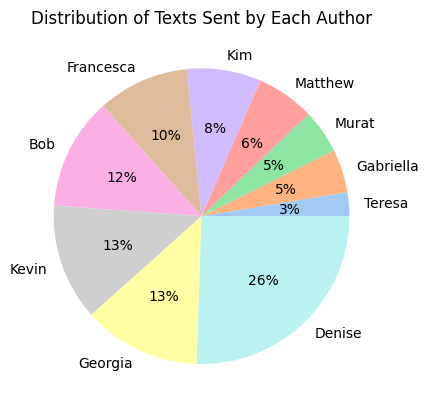

In [349]:
# As we previously edited the authors column to be a category data type, we can easily count how many messages were sent by each person using the groupby function 
grouped_df = filtered_df.groupby('Author')
group_sizes = grouped_df.size()

#category = df.category_name_column.value_counts()  
group_sizes_df = group_sizes.reset_index()
group_sizes_df.columns = ['Author', 'Frequency']
group_sizes_df = group_sizes_df.sort_values(by='Frequency')

palette = sns.color_palette("pastel")


# plotting data on chart 
plt.pie(group_sizes_df['Frequency'], labels=group_sizes_df['Author'], colors=color_mapping, autopct='%.0f%%') 
  
# displaying chart 
plt.title("Distribution of Texts Sent by Each Author")
plt.show() 




2) Who used the most emojis?

This is found by calculating who used the most emojis in their texts overall through using the emoji library to detect an emoji

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_55429/4286897432.py:19: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0.5, 1.0, 'Number of Emojis Sent by Each Author')

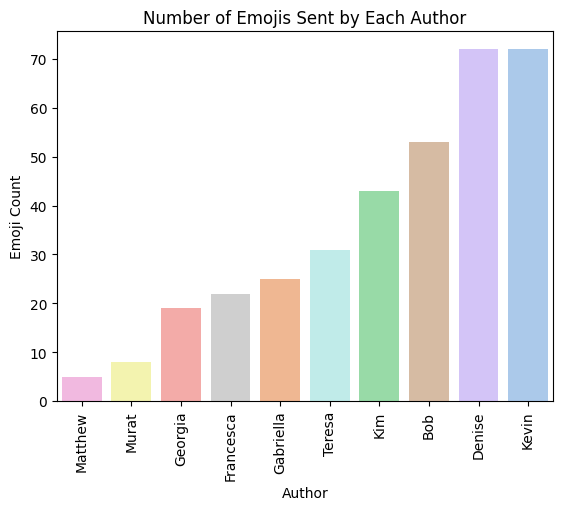

In [352]:
emojis_df = filtered_df.copy()

# Function to count the number of emojis in a string
def count_emojis(text):
    return emoji.emoji_count(text)


# Apply the function to the 'Message' column
emojis_df['emoji_count'] = emojis_df['Message'].apply(count_emojis)


sum_by_category = emojis_df.groupby('Author')['emoji_count'].sum()
sum_by_category = sum_by_category.reset_index()
sum_by_category.columns = ['Author', 'Emoji Count']
sum_by_category = sum_by_category.sort_values(by='Emoji Count')


emoji_count_plot = sns.barplot(data=sum_by_category, x = 'Author', y = 'Emoji Count', order=sum_by_category.sort_values('Emoji Count').Author, palette=color_mapping2, hue = 'Author')
emoji_count_plot.set_xticklabels(emoji_count_plot.get_xticklabels(), rotation=90)
emoji_count_plot.set_title("Number of Emojis Sent by Each Author")



3. Who asked the most questions?

This is found by finding who used the most question marks in their texts overall

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_55429/341167187.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0.5, 1.0, 'Number of Questions Asked by Each Author')

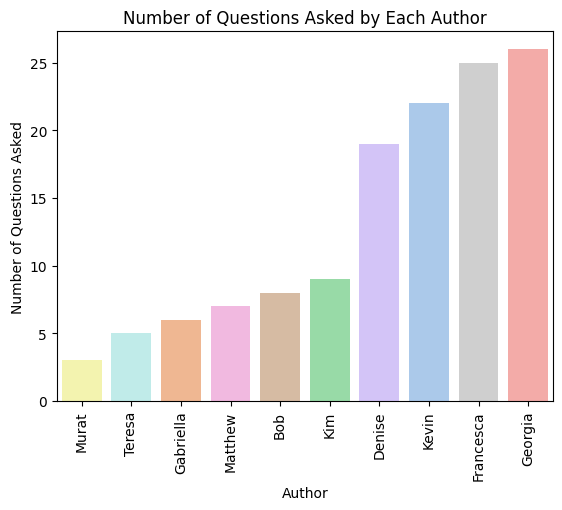

In [353]:
questions_df = filtered_df.copy()

questions_df['question'] = questions_df['Message'].str.contains("\?")

no_questions_df = questions_df.groupby('Author')['question'].sum()
no_questions_df = no_questions_df.reset_index()
no_questions_df.columns = ['Author', 'Number of Questions Asked']
no_questions_df = no_questions_df.sort_values(by='Number of Questions Asked')


questions_count_plot = sns.barplot(data=no_questions_df, x = 'Author', y = 'Number of Questions Asked', order=no_questions_df.sort_values('Number of Questions Asked').Author, palette=color_mapping2, hue = 'Author')
questions_count_plot.set_xticklabels(questions_count_plot.get_xticklabels(), rotation=90)
questions_count_plot.set_title("Number of Questions Asked by Each Author")

4. Distribution of when the texts were sent by the whole chat

This is an extra plot to lead on to the next question but shows the distribution of messages sent over time by the family. Here we can see that the family is most active on the chat at two points during the day - at around 9 and at around 6. This would allign well with when the majority of members in the chat wake up or have free time e.g walk their dogs, and when work finished and people are active on the chat again.

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_55429/2009812451.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_55429/2009812451.py:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


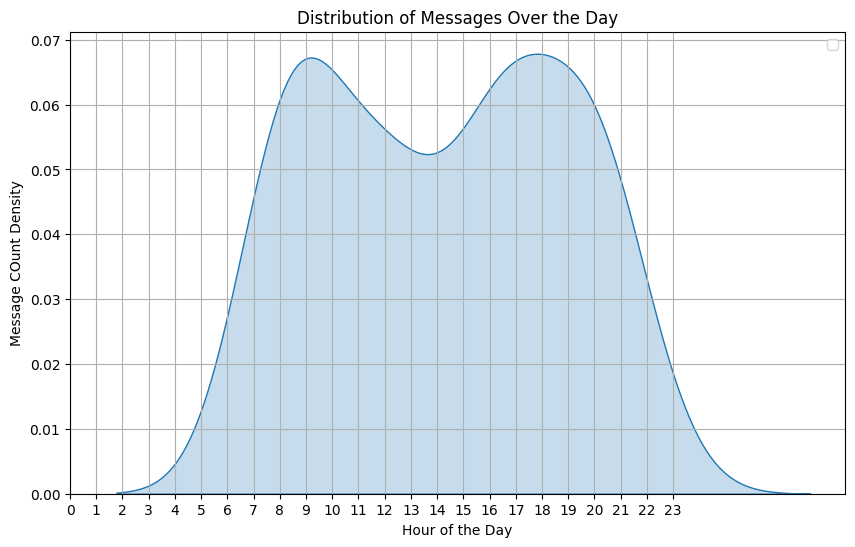

In [354]:
times_df = filtered_df.copy()

#convert to a date time
times_df['Time'] = pd.to_datetime(times_df['Time'])

times_df['hour'] = times_df['Time'].dt.hour

# Plot distribution for each author
plt.figure(figsize=(10, 6))

sns.kdeplot(data=group['hour'], shade=True)


plt.xlabel('Hour of the Day')
plt.ylabel('Message COunt Density')
plt.title('Distribution of Messages Over the Day')
plt.legend()
plt.grid(True)
plt.xticks(range(24))
plt.show()

4.Who wrote the most messages at night?

This is found through filtering the data between what could be considered "night time - 8:00 and 4:00 in the morning and then counting the number of messages. Overall this distribution doesn't differ much from who sent the most messages overall so I may do some more exploring around this question

/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_55429/3046289929.py:18: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'Teresa'),
 Text(1, 0, 'Gabriella'),
 Text(2, 0, 'Kim'),
 Text(3, 0, 'Kevin'),
 Text(4, 0, 'Georgia'),
 Text(5, 0, 'Francesca'),
 Text(6, 0, 'Matthew'),
 Text(7, 0, 'Bob'),
 Text(8, 0, 'Murat'),
 Text(9, 0, 'Denise')]

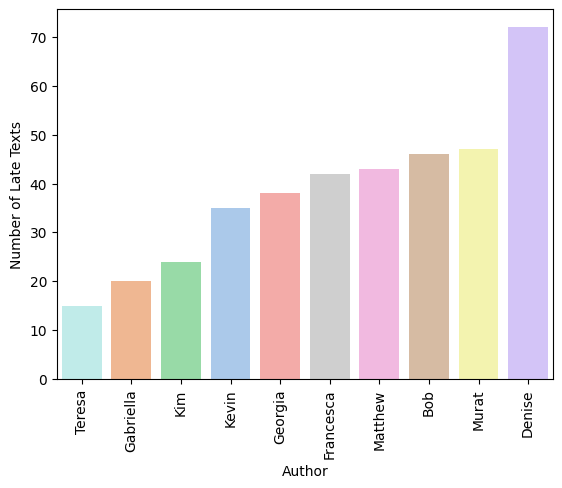

In [355]:

start_time = pd.to_datetime('20:00:00').time()
end_time = pd.to_datetime('4:00:00').time()

late_times_df = times_df[(times_df['Time'].dt.time >= start_time) | (times_df['Time'].dt.time <= end_time)]


#plot
no_late_texts_df = late_times_df.groupby('Author')['Message'].count()
no_late_texts_df = no_late_texts_df.reset_index()
no_late_texts_df.columns = ['Author', 'Number of Late Texts']
no_late_texts_df = no_late_texts_df.sort_values(by='Number of Late Texts')
no_late_texts_df.head()

palette = sns.color_palette("pastel")

late_texts_count_plot = sns.barplot(data=no_late_texts_df, x = 'Author', y = 'Number of Late Texts', order=no_late_texts_df.sort_values('Number of Late Texts').Author, palette=color_mapping2, hue = 'Author')
late_texts_count_plot.set_xticklabels(late_texts_count_plot.get_xticklabels(), rotation=90)



What was the most used emoji?

Who sent the most images and videos?

5. Whos name was mentioned most in the chat?

We have already converted to lower case and removed punctuation. Now just need to create lists of names for each person to capture if they have been identified by their nickname, or in a differfent tense

I did not check for words such as "mum" or "dad" as these words are not easily assignable - even if you count the number of times and assign it by who sent the message the person could be saying "your dad" meaning they are not talking about their own dad.

In [356]:
Gabriella = ["gabriella", "ella", "gabri","gabriellas", "ellas", "gabris"]
Cesca = ["francesca","cesca","cescy","francescas","cescas","cescys"]
Matthew = ["matthew","matt","matty","matthews","matts","mattys"]
Georgia = ["georgia","george","georgie","georgias","georges","georgies"]
Murat = ["murat","murats"]
Teresa = ["teresa","teresas"]
# remember to change dad's name in contacts when next downloading as he is currently being saved as "dad", so if some one mentions him by @ him i haven't counted it as dad could
# refer to other people
Kevin = ["kevin","kevins"]
Denise = ["denise", 'denises']
Bob = ["bob", 'bobs']
Kim = ["kim", "kims"]
Delilah = ["delilah", "delilahs"]
Joe = ["joe", "joes"]
Ethan = ["ethan", "ethans"]
Eleanor = ["eleanor", "eleanors"]

total_list = [Gabriella,Cesca,Matthew,Georgia,Murat,Teresa,Kevin,Denise,Bob,Kim,Delilah, Joe, Ethan, Eleanor]

names_count = []

for name in total_list:
    name_total = sum(text.count(word) for word in name)
    name = name[0].capitalize()
    names_count = names_count + [[name, name_total]]



print(names_count)  


[['Gabriella', 32], ['Francesca', 27], ['Matthew', 19], ['Georgia', 21], ['Murat', 12], ['Teresa', 17], ['Kevin', 25], ['Denise', 25], ['Bob', 13], ['Kim', 16], ['Delilah', 13], ['Joe', 12], ['Ethan', 4], ['Eleanor', 2]]


/var/folders/0m/16j__psx09997b7hk2fmlx7r0000gn/T/ipykernel_55429/1822181873.py:4: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'Eleanor'),
 Text(1, 0, 'Ethan'),
 Text(2, 0, 'Murat'),
 Text(3, 0, 'Joe'),
 Text(4, 0, 'Bob'),
 Text(5, 0, 'Delilah'),
 Text(6, 0, 'Kim'),
 Text(7, 0, 'Teresa'),
 Text(8, 0, 'Matthew'),
 Text(9, 0, 'Georgia'),
 Text(10, 0, 'Kevin'),
 Text(11, 0, 'Denise'),
 Text(12, 0, 'Francesca'),
 Text(13, 0, 'Gabriella')]

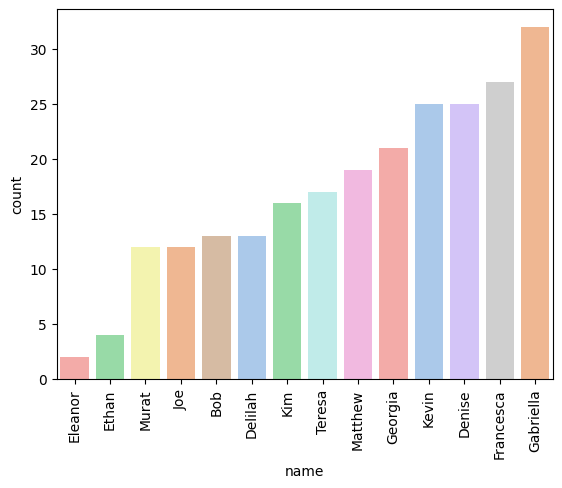

In [357]:
names_count_df = pd.DataFrame(names_count, columns=['name', 'count'])

names_count_plot = sns.barplot(data=names_count_df, x = 'name', y = 'count', order=names_count_df.sort_values('count').name, palette=color_mapping2, hue = 'name')
names_count_plot.set_xticklabels(names_count_plot.get_xticklabels(), rotation=90)


6. Best Friends... Who interacted with eachother most in the chat?

This code is to create a heat map of how people interacted with each other in the chat and show how interacted with each other the most. The data is based on messages sent after each other by different authors counting as an interaction. There are definately limitations in this model however it is one of the easiest ways at the moment to suggest who is involved in conversations with each other. 
The code creates a nested dictionary, counting the number of times that the person in the key responded to the author above ( the nested key). The code then goes through the nested dictionary and sums the mirrored values to get the total number of messages corresponded between the two authors. If the relationship is one sided (so one person hasn't responded to any of another authors messages), then both values are set to zero as it suggest a one sided conversation and not "best friends"

In [338]:
author_list = ['Gabriella','Mother Teresa','Aunty kim','Georgia','Cesca','Dad','Matthew','Uncle Bob','Aunty Denise','Murat']

# Initialize a dictionary to keep track of author tallies
author_tally = {}
 # List to store the tally counts for each row
tally_counts = []

previous_author = "Ben"
for index, row in filtered_df.iterrows():
        current_author = row['Author']
        
        # Update the tally count for the current author
        if current_author not in author_tally:
            author_tally[current_author] = {}

        # if index == :
        #       previous_author = current_author
        #       pass #can only start counting previous authors after the first row
        
            
        if previous_author != current_author:    
            if previous_author not in author_tally[current_author]:
                author_tally[current_author][previous_author] = 0
                
            #Increment the tally for the current author
            author_tally[current_author][previous_author] += 1
   
        #Assign who the previous author is going to be for the next
        previous_author = current_author
    
#Add up the total amount for each pair and print of the largest number - not including replies to themselves

print(author_tally)


{'Gabriella': {'Ben': 1, 'Aunty kim': 5, 'Bob': 13, 'Georgia': 10, 'Francesca': 2, 'Denise': 16, 'Kevin': 4, 'Teresa': 4, 'Matthew': 7, 'Murat': 1}, 'Aunty kim': {'Gabriella': 9, 'Kevin': 17, 'Francesca': 5, 'Denise': 43, 'Teresa': 4, 'Bob': 32, 'Georgia': 20, 'Murat': 3, 'Matthew': 4}, 'Denise': {'Aunty kim': 51, 'Gabriella': 17, 'Matthew': 24, 'Bob': 31, 'Kevin': 63, 'Teresa': 20, 'Murat': 8, 'Francesca': 29, 'Georgia': 39}, 'Bob': {'Denise': 47, 'Francesca': 32, 'Matthew': 22, 'Gabriella': 8, 'Georgia': 42, 'Aunty kim': 13, 'Kevin': 31, 'Teresa': 4, 'Murat': 13}, 'Matthew': {'Bob': 19, 'Francesca': 8, 'Aunty kim': 8, 'Kevin': 4, 'Georgia': 10, 'Denise': 16, 'Gabriella': 9, 'Teresa': 2, 'Murat': 3}, 'Francesca': {'Matthew': 3, 'Denise': 34, 'Georgia': 21, 'Bob': 29, 'Aunty kim': 11, 'Kevin': 15, 'Teresa': 3, 'Gabriella': 5, 'Murat': 1}, 'Kevin': {'Bob': 46, 'Francesca': 14, 'Georgia': 25, 'Aunty kim': 25, 'Gabriella': 2, 'Teresa': 3, 'Denise': 44, 'Matthew': 4, 'Murat': 3}, 'Murat': 

In [317]:
def add_mirrored_values(dictionary):
    summed_data = {}
    #loop throught the dictionary
    for key, nested_dict in dictionary.items():
        if key not in summed_data:
            summed_data[key] = {}
        #loop through the nested dictionary
        for nested_key, value in nested_dict.items():
            #check if the mirrored value exists
            if nested_key in dictionary and key in dictionary[nested_key]:
                if nested_key not in summed_data[key]:
                    summed_data[key][nested_key] = {}
                # if it exists, define the value and add the value to the new dictionary
                value = dictionary[key][nested_key]
                mirrored_value = dictionary[nested_key][key]
                summed_data[key][nested_key] = value + mirrored_value
    return (summed_data)

summed_data = add_mirrored_values(author_tally)
print(summed_data)

{'Gabriella': {'Aunty kim': 14, 'Bob': 21, 'Georgia': 20, 'Francesca': 7, 'Denise': 33, 'Kevin': 6, 'Teresa': 7, 'Matthew': 16}, 'Aunty kim': {'Gabriella': 14, 'Kevin': 42, 'Francesca': 16, 'Denise': 94, 'Teresa': 13, 'Bob': 45, 'Georgia': 32, 'Murat': 6, 'Matthew': 12}, 'Denise': {'Aunty kim': 94, 'Gabriella': 33, 'Matthew': 40, 'Bob': 78, 'Kevin': 107, 'Teresa': 39, 'Murat': 17, 'Francesca': 63, 'Georgia': 93}, 'Bob': {'Denise': 78, 'Francesca': 61, 'Matthew': 41, 'Gabriella': 21, 'Georgia': 66, 'Aunty kim': 45, 'Kevin': 77, 'Teresa': 8, 'Murat': 27}, 'Matthew': {'Bob': 41, 'Francesca': 11, 'Aunty kim': 12, 'Kevin': 8, 'Georgia': 22, 'Denise': 40, 'Gabriella': 16, 'Teresa': 3, 'Murat': 5}, 'Francesca': {'Matthew': 11, 'Denise': 63, 'Georgia': 45, 'Bob': 61, 'Aunty kim': 16, 'Kevin': 29, 'Teresa': 4, 'Gabriella': 7, 'Murat': 7}, 'Kevin': {'Bob': 77, 'Francesca': 29, 'Georgia': 52, 'Aunty kim': 42, 'Gabriella': 6, 'Teresa': 7, 'Denise': 107, 'Matthew': 8, 'Murat': 4}, 'Murat': {'France

In [187]:
import numpy as np

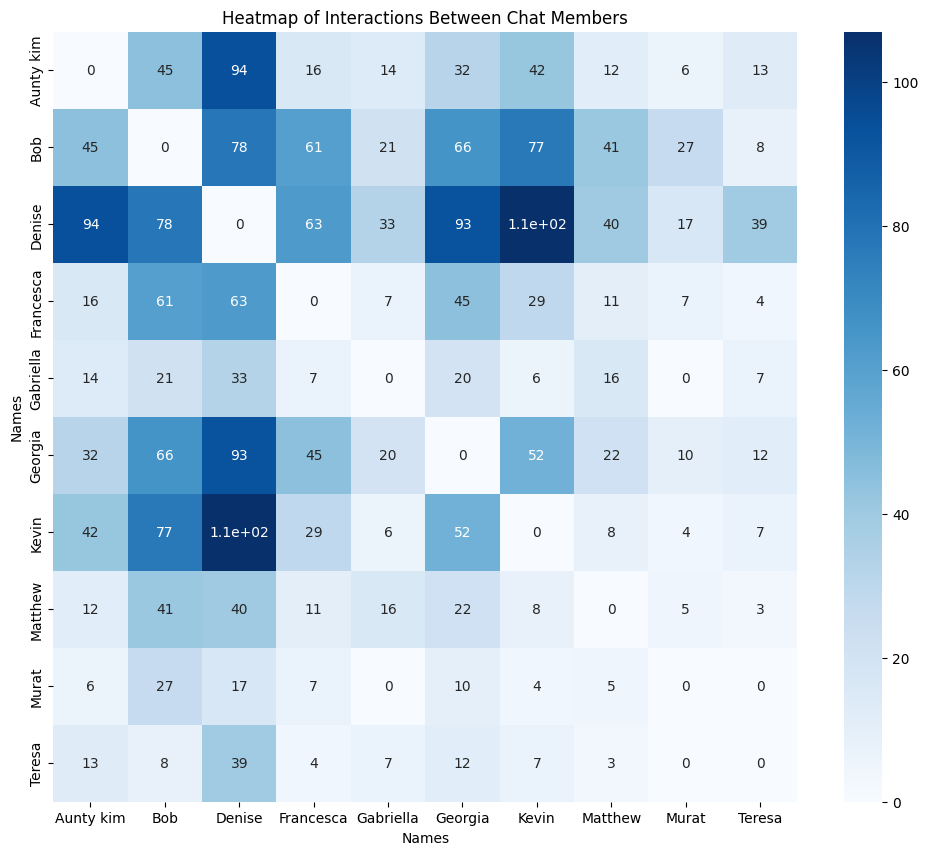

In [340]:
#Turn the data into a pandas data frame

# Create a sorted list of all unique names for consistent heatmap ordering
all_names = sorted(set(summed_data.keys()).union(*[d.keys() for d in summed_data.values()]))

# Create an empty matrix to populate with values
matrix = np.zeros((len(all_names), len(all_names)))

# Populate the matrix with the dictionary values
for i, name1 in enumerate(all_names):
    for j, name2 in enumerate(all_names):
        if name2 in summed_data.get(name1, {}):
            matrix[i, j] = summed_data[name1][name2]

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, xticklabels=all_names, yticklabels=all_names, annot=True, cmap="Blues")
plt.title('Heatmap of Interactions Between Chat Members')
plt.xlabel('Names')
plt.ylabel('Names')
plt.show()